In [1]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.run_functions_eagerly(True)

In [2]:
problem = "Pendulum-v0"
env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


In [3]:
class Buffer:
    def __init__(self, capacity=100000):
        # Number of "experiences" to store at max
        self.capacity = capacity
        self.counter = 0
        self.batch_size = 64
        self.state_buffer = np.zeros((self.capacity, num_states))
        self.action_buffer = np.zeros((self.capacity, num_actions))
        self.reward_buffer = np.zeros((self.capacity, 1))
        self.next_state_buffer = np.zeros((self.capacity, num_states))

    def insert(self, obs_tuple):
        index = self.index
        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.counter += 1
    
    def append(self, d):
        for i in d:
            self.insert(i)
    
    def sample(self):
        idx = np.random.choice(self.size, self.batch_size)
        
        state_batch = tf.convert_to_tensor(self.state_buffer[idx])
        action_batch = tf.convert_to_tensor(self.action_buffer[idx])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[idx])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[idx])
        
        return state_batch, action_batch, reward_batch, next_state_batch
    
    @property
    def raw(self):
        d = [(self.state_buffer[i], self.action_buffer[i], self.reward_buffer[i], self.next_state_buffer[i]) for i in range(self.size)]
        return d
            
    @property
    def size(self):
        if self.counter >= self.capacity:
            return self.capacity
        else:
            return self.counter
    
    @property
    def index(self):
        return self.counter % self.capacity
    
    @property
    def batches(self):
        state_batch = tf.convert_to_tensor(self.state_buffer)
        action_batch = tf.convert_to_tensor(self.action_buffer)
        reward_batch = tf.convert_to_tensor(self.reward_buffer)
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer)
        return state_batch, action_batch, reward_batch, next_state_batch

In [4]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [5]:
@tf.function
def ddpg_update(d, actor, actor_optimizer, critic, critic_optimizer, update_critic=True):
    state_batch, action_batch, reward_batch, next_state_batch = d.sample()
    
    if update_critic:
        with tf.GradientTape() as tape:
            target_actions = actor(next_state_batch, training=True)
            y = reward_batch + gamma * critic([next_state_batch, target_actions], training=True)
            critic_value = critic([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grad, critic.trainable_variables))

    with tf.GradientTape() as tape:
        actions = actor(state_batch, training=True)
        critic_value = critic([state_batch, actions], training=True)
        # Used `-value` as we want to maximize the value given
        # by the critic for our actions
        actor_loss = -tf.math.reduce_mean(critic_value)

    actor_grad = tape.gradient(actor_loss, actor.trainable_variables)
    actor_optimizer.apply_gradients(zip(actor_grad, actor.trainable_variables))

# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def target_update(target, model):
    target.variables = model.variables

In [6]:
@tf.function
def teacher_update(actor, actor_optim, critic, critic_optim, d, meta):
    state_batch, action_batch, reward_batch, _ = d.sample()
    
    with tf.GradientTape() as tape:
        actions = actor(state_batch, training=True)
        reward = critic([state_batch, actions], training=False)
        log_reward = tf.math.log(reward)
        actor_loss = tf.math.multiply(tf.cast(meta, dtype="float32"), tf.reduce_sum(log_reward))
        
    actor_grad = tape.gradient(actor_loss, actor.trainable_variables)
    actor_optim.apply_gradients(zip(actor_grad, actor.trainable_variables))
    
    return actor_loss.numpy()
    
#     with tf.GradientTape() as tape:
#         reward = critic([state_batch, action_batch], training=True)
#         critic_loss = tf.math.reduce_mean(tf.math.square(reward - reward_batch))
    
#     critic_grad = tape.gradient(critic_loss, critic.trainable_variables)
#     critic_optim.apply_gradients(zip(critic_grad, critic.trainable_variables))
    

In [7]:
# give: policy(model) and current state
# return: next action
def next_action(policy, state):
    state = np.expand_dims(state, axis=0)
    
    sampled_actions = tf.squeeze(policy(state))
    sampled_actions = sampled_actions.numpy()

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

# sample n steps using policy
# give: policy, n
# return: [sars], accumulated reward
def generate(policy, n):
    prev_state = env.reset()
    d = []
    total_reward = 0
    for i in range(n):
        action = next_action(policy, prev_state)
        state, reward, done, _ = env.step(action)
        total_reward += reward
        d.append((prev_state, action, reward, state))
        prev_state = state
        if done:
            break
            
    return d, total_reward

def copy(model):
    new_model = tf.keras.models.clone_model(model)
    new_model.set_weights(model.get_weights())
    
    return new_model


In [8]:
std_dev = 0.2

# Learning rate for actor-critic models
teacher_lr = 0.0001
actor_lr = 0.0001
critic_lr = 0.001

total_iterations = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
d0_rollout = 100
d1_rollout = 200
pi_rollout = 50
buffer_capacity = 50000
log_interval = 50

# To store reward history of each episode
it_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []
meta_reward_list = []
teacher_loss_list = []

In [9]:
# Step 1: Initialize pi
teacher_actor = get_actor()
teacher_critic = get_critic()

# Step 1: Initialize pie
actor = get_actor()
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
critic = get_critic()
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)

# Making the weights equal initially
teacher_actor.set_weights(actor.get_weights())
teacher_actor_optim = tf.keras.optimizers.Adam(actor_lr)
teacher_critic.set_weights(critic.get_weights())
teacher_critic_optim = tf.keras.optimizers.Adam(critic_lr)

# Step 2:
d0, d1 = Buffer(d0_rollout), Buffer(d1_rollout)
data, meta_pi = generate(actor, d1_rollout)
d1.append(data)

# Step 3:
buffer = Buffer(buffer_capacity)
buffer.append(d1.raw)

Iteration 0
Meta Reward: -214.50573771670292
Teacher Loss: nan
Avg Reward: -1295.2051151497164
Iteration 1
Meta Reward: 124.16771708482975
Teacher Loss: nan
Avg Reward: -1021.6488475494796
Iteration 2
Meta Reward: 120.09205731091379
Teacher Loss: -26209.57
Avg Reward: -1134.8120892693169
Iteration 3
Meta Reward: -406.07222339038367
Teacher Loss: nan
Avg Reward: -1035.769953975464
Iteration 4
Meta Reward: -748.4349706102238
Teacher Loss: nan
Avg Reward: -1051.5556846389331
Iteration 5
Meta Reward: -196.39058336983135
Teacher Loss: 31658.086
Avg Reward: -1021.1264176549776
Iteration 6
Meta Reward: -734.9223401116133
Teacher Loss: nan
Avg Reward: -1027.2282173675305
Iteration 7
Meta Reward: -480.60508374966207
Teacher Loss: nan
Avg Reward: -1003.5807575318065
Iteration 8
Meta Reward: -384.18868026943665
Teacher Loss: 66149.664
Avg Reward: -994.7380806182025
Iteration 9
Meta Reward: -569.3707282166987
Teacher Loss: 114489.42
Avg Reward: -1029.4334490156034
Iteration 10
Meta Reward: -352.21

Avg Reward: -1386.4544993760999
Iteration 84
Meta Reward: -9.007622074375377
Teacher Loss: 1593.8855
Avg Reward: -1379.3856128839009
Iteration 85
Meta Reward: -552.9026438936173
Teacher Loss: 94536.49
Avg Reward: -1385.8496420376384
Iteration 86
Meta Reward: 882.7473446184304
Teacher Loss: nan
Avg Reward: -1383.7407946731278
Iteration 87
Meta Reward: -356.8332944017527
Teacher Loss: nan
Avg Reward: -1390.3381854081276
Iteration 88
Meta Reward: 118.38733431385617
Teacher Loss: nan
Avg Reward: -1389.810148793916
Iteration 89
Meta Reward: -36.13247567406893
Teacher Loss: 6953.6216
Avg Reward: -1404.3711671524804
Iteration 90
Meta Reward: 659.5680405989021
Teacher Loss: -115087.49
Avg Reward: -1414.2552510238343
Iteration 91
Meta Reward: -188.47211708072382
Teacher Loss: 38383.145
Avg Reward: -1420.3937091267082
Iteration 92
Meta Reward: 36.78535378088509
Teacher Loss: nan
Avg Reward: -1421.5938631144152
Iteration 93
Meta Reward: 419.046080998369
Teacher Loss: nan
Avg Reward: -1419.0935105

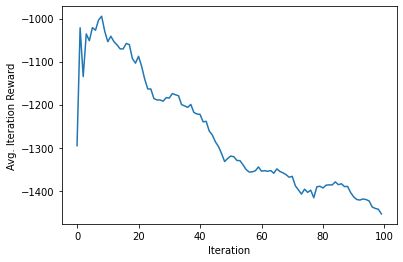

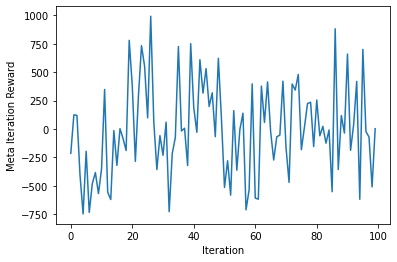

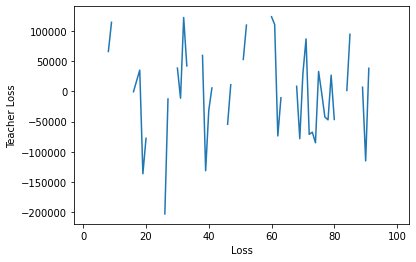

In [10]:
# Step 4:
for it in range(total_iterations):
    print('Iteration', it)
    # Step 5: Generate d0
    data, _ = generate(teacher_actor, d0_rollout)
    d0.append(data)
    
    # Step 6: Update pi to temp
    # ********* ddpg_update的optimizer用 actor_optimizer (不知道會不會出事)
    temp = copy(actor)
    ddpg_update(d0, temp, actor_optimizer, critic, critic_optimizer, update_critic=False)
    
    # Step 7: 
    data, meta_pip = generate(temp, d1_rollout)
    d1.append(data)
    meta = meta_pip - meta_pi
    print('Meta Reward:', meta)
    
    # Step 8:
    loss = teacher_update(teacher_actor, teacher_actor_optim, teacher_critic, teacher_critic_optim, d0, meta)
    print('Teacher Loss:', loss)
    teacher_loss_list.append(loss)

    # Step 9:
    buffer.append(d0.raw)
    buffer.append(d1.raw)
    
    # Step 10:
    ddpg_update(buffer, actor, actor_optimizer, critic, critic_optimizer)
    data_temp, meta_pi = generate(actor, d1_rollout)
    
    meta_reward_list.append(meta)
    it_reward_list.append(meta_pi)
    avg_reward = np.mean(it_reward_list[-40:])
    print("Avg Reward:", avg_reward)
    avg_reward_list.append(avg_reward)
    
plt.plot(avg_reward_list)
plt.xlabel("Iteration")
plt.ylabel("Avg. Iteration Reward")
plt.show()

plt.plot(meta_reward_list)
plt.xlabel("Iteration")
plt.ylabel("Meta Iteration Reward")
plt.show()

plt.plot(teacher_loss_list)
plt.xlabel("Loss")
plt.ylabel("Teacher Loss")
plt.show()